# Transfer Learning for Image Classification

- ###### Transfer learning involves leveraging knowledge gained from training a model on a generic dataset, typically consisting of millions of images, and fine-tuning it on a specific dataset of interest. This technique allows the model to adapt its learned features to the characteristics of the new dataset quickly, potentially improving performance and efficiency.
- ###### Transfer learning is a technique where knowledge gained from one task is leveraged to solve another similar task.

- **Topics are covered in the chapter**:
    - Introducing transfer learning
    - Understanding VGG16 and ResNet architectures
    - Implementing facial key point detection
    - Multi-task learning: Implementing age estimation and gender classification
    - Introducing the torch_snippets library

**Transfer Learning High-Level Flow:**

1. **Input Normalization:**
   - Normalize input images using the same mean and standard deviation as used during the training of the pre-trained model.

2. **Fetch Pre-trained Model:**
   - Obtain the architecture of the pre-trained model.
   - Fetch the weights learned by the pre-trained model on a large dataset.

3. **Truncate Pre-trained Model:**
   - Remove the last few layers of the pre-trained model.

4. **Connect to New Layers:**
   - Connect the truncated pre-trained model to a newly initialized layer (or layers).
   - Ensure the output of the last layer matches the number of classes/outputs for prediction.

5. **Freeze Pre-trained Weights:**
   - Make the weights of the pre-trained model non-trainable (frozen) during backpropagation.
   - Train only the weights of the newly initialized layer and those connecting it to the output layer.
     - Rationale: Leverage the well-learned features of the pre-trained model for the task at hand.

6. **Training:**
   - Update the trainable parameters (weights of the new layers) over increasing epochs to fit the model to the specific dataset.
   - Gradually fine-tune the model on the smaller dataset, allowing it to adapt to specific features while retaining the knowledge from the pre-trained model.

---

# Understanding VGG16 architecture

- ###### `VGG` stands for `Visual Geometry Group`, which is based out of the University of Oxford, and 16 stands for the number of layers in the model. The VGG16 model is trained to classify objects in the ImageNet competition and stood as the runner-up architecture in 2014.

In [1]:
# 1. Import the required packages
import torchvision
from torchvision import models , transforms , datasets
import torch
import torch.nn as nn
import torch.nn.functional as f
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# 2. Load the VGG16 model and register the model within the device
model = models.vgg16(weights='IMAGENET1K_V1').to(device)

# 3. Fetch the summary of the model
summary(model,torch.zeros(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

- The 16 layers we mentioned are grouped as follows:

    - {1,2},{3,4,5},{6,7},{8,9,10},{11,12},{13,14},{15,16,17},{18,19},{20,21},{22,23,24},{25,26},{27,28},{29,30,31,32},{33,3 4,35},{36 37,38},{39}



- `Note` that there are ~138 million parameters (of which ~122 million are the linear layers at the end of the network – 102 + 16 + 4 million parameters) in this network, which comprises 13 layers of convolution and/or pooling, with increasing number of filters, and 3 linear layers.

In [4]:
# Another way to understand the components of the VGG16 model is by simply printing 
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

- Model has three sub-modules: features, avgpool, and classifier.
- It's common to freeze features and avgpool during transfer learning.
- Remove the classifier module (or some bottom layers).
- Replace it with a new classifier for the specific dataset classes.
- Adapt the output to predict the desired number of classes (not the original 1,000).

In [1]:
# 1. Import and install required packages
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
import torchvision
from torchsummary import summary
from torchvision import datasets, transforms, models    
import matplotlib.pyplot as plt
from PIL import Image
from random import  seed,shuffle
import numpy as np
import cv2
import os
import glob
import pandas as pd
from glob import glob

# Set device to 'cuda' if available, otherwise use 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
# 2. Download the dataset
## ## Specify the training and test image folders
train_image_dir = 'DataSet/training_set'
test_image_dir = 'DataSet/test_set'

# 3. Provide the class that returns input-output pairs for the cats and dogs data
class CatsDogs(Dataset):
    NUM_IMAGES = 500

    def __init__(self, folder):
        cats = glob(os.path.join(folder, 'cats', '*.jpg'))
        dogs = glob(os.path.join(folder, 'dogs', '*.jpg'))
        self.fpaths = cats[:self.NUM_IMAGES] + dogs[:self.NUM_IMAGES]
        self.normalize = transforms.Normalize(  mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])
        seed(10)
        shuffle(self.fpaths)
        self.targets = [os.path.splitext(os.path.basename(fpath))[0].startswith('dog') for fpath in self.fpaths]

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, idx):
        f = self.fpaths[idx]
        target = self.targets[idx]
        im = cv2.imread(f)[:, :, ::-1]
        im = cv2.resize(im, (224, 224))
        im = torch.tensor(im / 255.).permute(2, 0, 1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)
        



- When using pre-trained models, certain preprocessing steps are necessary to ensure the input data is compatible with the model. These steps include:

    1. **Resizing**: The input images must be resized to match the input size expected by the model.

    2. **Permuting**: The dimensions of the image tensor may need to be rearranged. For example, many PyTorch models expect the channel dimension to be the first dimension.

    3. **Scaling**: The pixel values of the images, which typically range from 0 to 255, should be scaled to fall within the range 0 to 1. This is done by dividing each pixel value by 255.

    4. **Normalizing**: The images should be normalized such that their RGB channels have a mean of [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225]. This is typically done using a normalization transform provided by the deep learning framework.

These preprocessing steps ensure that the input data is in a format and scale that the pre-trained model expects, which is crucial for the model to make accurate predictions.

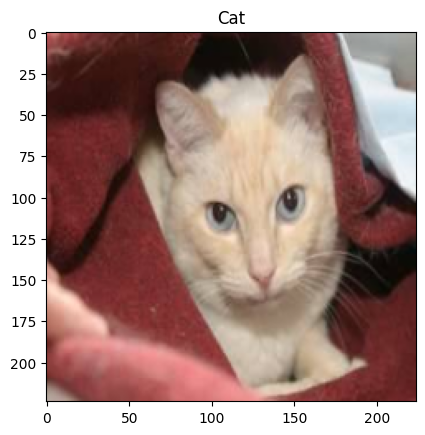

In [3]:
# 4. Fetch the training and test data
data = CatsDogs(train_image_dir)

# Denormalize function
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    return tensor * std + mean

##  inspect a sample image and its corresponding class
im, label = data[200]
im = denormalize(im.to('cpu'))  # Denormalize the image
plt.imshow(im.permute(1, 2, 0))
plt.title('Dog' if label else 'Cat')
plt.show()

In [4]:
# 5. Define the model
## download the pretrained VGG16 model from the models class
def get_model():
    model = models.vgg16(weights='IMAGENET1K_V1')

    #  freeze all the parameters in the model
    for param in model.parameters():
        param.requires_grad = False

    # Replace the avgpool module to return a feature map of size 1 x 1instead of 7 x 7
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    # Define the classifier module of the model
    model.classifier = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    # Define the loss function , optimizer
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

- **Pooling Layers Overview:**
  - Two common pooling layers are `nn.MaxPool2d` and its counterpart `nn.AvgPool2d`.
  - `nn.MaxPool2d` returns the maximum value within a section defined by a fixed kernel size.
  - `nn.AvgPool2d` returns the average value within a section with the same fixed kernel size.
  - Both layers have a predetermined kernel size.
  
- **Adaptive Average Pooling:**
  - Another pooling layer, `nn.AdaptiveAvgPool2d`, has a unique feature.
  - It requires specifying the output feature map size rather than a fixed kernel size.
  - The layer automatically computes the kernel size to achieve the specified feature map size.
  - For instance, if the input feature map size is batch_size x 512 x k x k, the pooling kernel size becomes k x k.
  
- **Advantages of Adaptive Average Pooling:**
  - Output from this layer is always fixed, regardless of the input size.
  - This allows the neural network to accept images of varying height and width.


In [5]:
# summary of the model
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1, 3, 224, 224).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

- **Trainable Parameters:**
  - Total trainable parameters: 14.7 million.
  - Frozen features module: No updates to its parameters.
  - Overwritten avgpool and classifier modules.
  - Number of trainable parameters reduced to 65,793.
  - Only the classifier module retains weights for learning.


In [6]:
# 6. Create the get_data function, which creates an object of the cats_dogs class and creates a DataLoader with a batch_size of 32 for both the training and validation folders
def get_data():
    # Instantiate the cats_dogs class for training data
    train_dataset = CatsDogs(train_image_dir)
    
    # Create a DataLoader for training data with a batch size of 32, enabling shuffling and dropping the last incomplete batch
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
    
    # Instantiate the cats_dogs class for validation data
    val_dataset = CatsDogs(test_image_dir)
    
    # Create a DataLoader for validation data with a batch size of 32, enabling shuffling and dropping the last incomplete batch
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
    
    # Return the training and validation DataLoaders
    return train_dataloader, val_dataloader


# 7. Define the function that will train the model on a batch of data
def train_batch(input_data, target, model, optimizer, loss_function):
    # Set the model to training mode
    model.train()

    # Forward pass
    predictions = model(input_data)

    # Compute the batch loss
    batch_loss = loss_function(predictions, target)

    # Backward pass and optimization
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Return the batch loss as a Python float
    return batch_loss.item()


# 8. Define the functions for calculating accuracy and validation loss
## Define the accuracy function
@torch.inference_mode()
def calculate_accuracy(input_data, target, model):
    # Get model predictions
    predictions = model(input_data)

    # Determine correctness of predictions
    is_correct = (predictions > 0.5) == target

    # Convert to a list of boolean values and return
    return is_correct.cpu().numpy().tolist()

## Define the validation loss calculation function
@torch.inference_mode()
def calculate_validation_loss(input_data, target, model, loss_function):
    # Get model predictions
    predictions = model(input_data)

    # Calculate the validation loss
    validation_loss = loss_function(predictions, target)

    # Return the validation loss as a Python float
    return validation_loss.item()

# 9. Train the model for 5 epochs and check the accuracy of the test data at the end of each epoch
def train_and_validate(model, trn_dl, val_dl, loss_fn, optimizer, num_epochs=5):
    train_losses, train_accuracies = [], []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch: {epoch}")

        # Training
        model.train()
        train_epoch_losses, train_epoch_accuracies = [], []
        for batch in trn_dl:
            x, y = batch
            batch_loss = train_batch(x, y, model, optimizer, loss_fn)
            train_epoch_losses.append(batch_loss)

            is_correct = calculate_accuracy(x, y, model)
            train_epoch_accuracies.extend(is_correct)

        train_epoch_loss = torch.tensor(train_epoch_losses).mean().item()
        train_epoch_accuracy = torch.tensor(train_epoch_accuracies).float().mean().item()

        # Validation
        model.eval()
        val_epoch_accuracies = []
        for batch in val_dl:
            x, y = batch
            val_is_correct = calculate_accuracy(x, y, model)
            val_epoch_accuracies.extend(val_is_correct)

        val_epoch_accuracy = torch.tensor(val_epoch_accuracies).float().mean().item()

        # Print and store results
        print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_accuracies.append(val_epoch_accuracy)

    return train_losses, train_accuracies, val_accuracies


# 10. Plot the variation of the training and validation accuracies over increasing epochs
def plot_training_validation_accuracies(train_accuracies, val_accuracies, num_epochs=5):
    """
    Plot the variation of training and validation accuracies over increasing epochs.

    Parameters:
    - train_accuracies (list): List of training accuracies for each epoch.
    - val_accuracies (list): List of validation accuracies for each epoch.
    - num_epochs (int): Number of epochs. Default is 5.
    """

    epochs = np.arange(1, num_epochs + 1)

    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')

    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [7]:
# Initialize the get_data and get_model functions
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

## Train the model over increasing epochs 2K data points
train_losses, train_accuracies, val_accuracies = train_and_validate(model, trn_dl, val_dl, loss_fn, optimizer)

Epoch: 1
Train Loss: 0.2420, Train Accuracy: 0.9597, Validation Accuracy: 0.9859
Epoch: 2
Train Loss: 0.0534, Train Accuracy: 0.9819, Validation Accuracy: 0.9829
Epoch: 3
Train Loss: 0.0333, Train Accuracy: 0.9909, Validation Accuracy: 0.9819
Epoch: 4
Train Loss: 0.0270, Train Accuracy: 0.9919, Validation Accuracy: 0.9819
Epoch: 5
Train Loss: 0.0194, Train Accuracy: 0.9950, Validation Accuracy: 0.9808


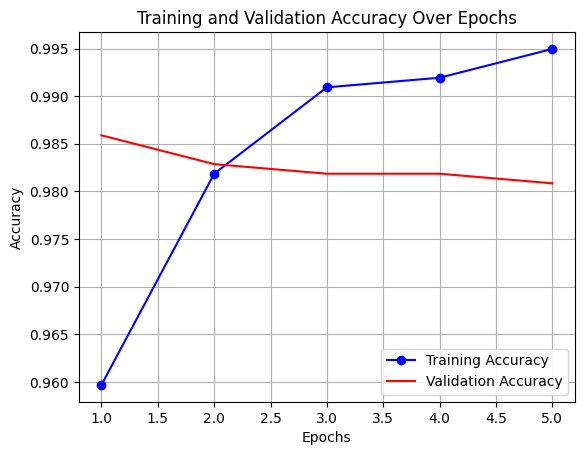

In [8]:
plot_training_validation_accuracies(train_accuracies, val_accuracies, 5)


## Model Accuracy:
- VGG19-based model: 98% accuracy on validation data.
- VGG16-based model: Slightly lower accuracy compared to VGG19.
- VGG11-based model: 97% accuracy.

## Layer Depth and Accuracy:
- Generally, deeper neural networks (increased layers) lead to better accuracy.
- Transition from VGG16 to VGG19 involves increasing the number of layers.

## Increasing Layers:
- Simply adding more layers to a model does not guarantee improved accuracy.
- Overfitting must be avoided during the addition of layers.

## Challenges with Deeper Architectures:
- Learning a larger number of features becomes necessary.
- Vanishing gradients can occur.
- Excessive information modification at deeper layers poses challenges.

**Note:** Fine-tuning after increasing layers may not lead to proportional improvements, and various issues such as vanishing gradients and information modification at deeper layers need to be addressed.


---

# Understanding ResNet architecture

### Problems with Deep Networks:
- Forward Propagation: Last few layers lack information about the original image.
- Backpropagation: First few layers near input receive almost zero gradient updates (vanishing gradients).

### ResNet Solution:
- Residual Networks (ResNet) address both forward and backward propagation issues.
- Utilizes highway-like connections to transfer raw information from previous layers to later layers.
- Aims to ensure the last layer has complete information about the original image.
- Facilitates smooth backward gradient flow to initial layers with minimal modification.


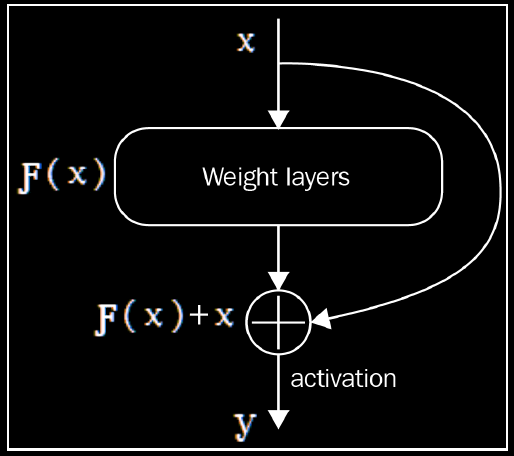

### Residual Concept:
- Term "`residual`" refers to additional information learned from the previous layer.
- ResNet extracts not only the transformed value (F(x)) but also sums it with the original value (x).

### Transformation Preservation:
- Traditional layers destroy input information through linear or convolution transformations.
- ResNet introduces a layer that not only transforms the input but also preserves it by adding the input directly to the transformation: F(x) + x.
- This approach reduces the burden on the layer to remember the input, allowing it to focus on learning the correct transformation for the task.


In [9]:
#  more detailed look at the residual layer through code by building a residual block
# 1. Define a class with the convolution operation
class ResLayer(nn.Module):
    def __init__(self,ni,no,kernel_size,stride=1) :
        super(ResLayer,self).__init__()
        padding = kernel_size -2
        self.conv = nn.Sequential(nn.Conv2d(ni,no,kernel_size,stride,
                                            padding=padding),
                                    nn.ReLU())
    def forward(self,x):
        x = self.conv(x) + x
        return x

- The `padding` variable is calculated as `kernel_size - 2`.
- The purpose of this calculation is to ensure that the output dimension of the convolution operation matches the input dimension when summed with the original input.

#### understand how the residual blocks are connected in a pre-trained, residual block-based network, ResNet18:

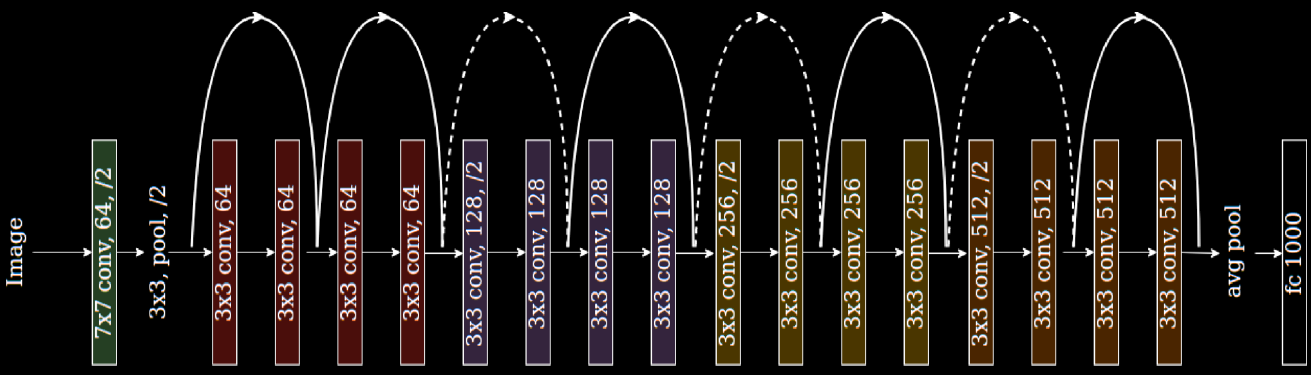

- The architecture consists of 18 layers, hence named ResNet18.
- Skip connections are a key feature in the network design.
- Skip connections are established not after every convolution layer but after every two layers.
- This structural choice contributes to the effectiveness of the ResNet architecture.


#### ResNet18 Model Structure

1. **Convolution**
2. **Batch Normalization**
3. **ReLU Activation**
4. **MaxPooling**
5. **Four Layers of ResNet Blocks**
6. **Average Pooling (avgpool)**
7. **Fully Connected Layer (fc)**


In [10]:
#  Define the model architecture, loss function, and optimizer
def get_model():
    model = models.resnet18(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(nn.Linear(512, 128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128, 1),
                            nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

In [11]:
# Initialize the get_data and get_model functions
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

## Train the model over increasing epochs 2K data points
train_losses, train_accuracies, val_accuracies = train_and_validate(model, trn_dl, val_dl, loss_fn, optimizer)

Epoch: 1
Train Loss: 0.3443, Train Accuracy: 0.8831, Validation Accuracy: 0.9637
Epoch: 2
Train Loss: 0.1187, Train Accuracy: 0.9607, Validation Accuracy: 0.9627
Epoch: 3
Train Loss: 0.1130, Train Accuracy: 0.9647, Validation Accuracy: 0.9798
Epoch: 4
Train Loss: 0.0976, Train Accuracy: 0.9577, Validation Accuracy: 0.9798
Epoch: 5
Train Loss: 0.0868, Train Accuracy: 0.9617, Validation Accuracy: 0.9667


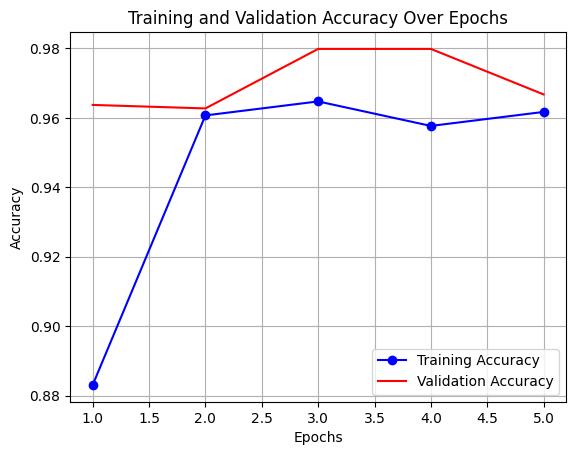

In [12]:
plot_training_validation_accuracies(train_accuracies, val_accuracies, 5)

#### Besides `VGG` and `ResNet`, some of the other prominent pre-trained models are `Inception`, `MobileNet`, `DenseNet`, and `SqueezeNet`.

---

# Implementing facial key point detection

- This section will be in `Facial_keypoints_detection.ipynb` Notebook
or tap here **[Facial_keypoints_detection_Code](https://colab.research.google.com/drive/1-gF_ipH9WD96wbiAUq83s_j97gHc1tQg?usp=sharing)**

---

# 2D and 3D facial key point detection